# Mod 5 Project: Classifying Loan Default
### Dataset: LendingClub 2007-11

In [52]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (16,9)

## EDA
#### Load CSV file and begin EDA

In [53]:
loan_df = pd.read_csv('LCloans_07.csv', skiprows = 1, low_memory = False)
display(loan_df.head())
display(loan_df.info())

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42535 entries, 0 to 42534
Columns: 150 entries, id to settlement_term
dtypes: float64(120), object(30)
memory usage: 48.7+ MB


None

In [54]:
# drop any values with more than half missing
half_na = len(loan_df)/2
loan_df = loan_df.dropna(thresh = half_na, axis = 1)
loan_df = loan_df.drop(['url','desc'], axis = 1)


In [55]:
loan_df.shape

(42535, 57)

In [56]:
#Drop irrelevant columns
drops = ['id', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'sub_grade', 'emp_title', 'issue_d', 'zip_code', 
         'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
         'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
         'pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 
         'chargeoff_within_12_mths', 'pub_rec_bankruptcies', 'tax_liens',
         'hardship_flag', 'debt_settlement_flag', 'delinq_amnt']
loan_df = loan_df.drop(columns = drops, axis = 1)

In [57]:
# Average fico score (unique to entry)
loan_df['avg_fico'] = (loan_df['fico_range_high'] + loan_df['fico_range_low'])/2

In [58]:
loan_df = loan_df.drop(columns = ['fico_range_low', 'fico_range_high', 'last_fico_range_low', 'last_fico_range_high'], axis = 1)

In [59]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42535 entries, 0 to 42534
Data columns (total 24 columns):
loan_amnt              42532 non-null float64
term                   42532 non-null object
installment            42532 non-null float64
grade                  42532 non-null object
emp_length             41420 non-null object
home_ownership         42532 non-null object
annual_inc             42528 non-null float64
verification_status    42532 non-null object
loan_status            42532 non-null object
purpose                42532 non-null object
title                  42519 non-null object
addr_state             42532 non-null object
dti                    42532 non-null float64
delinq_2yrs            42503 non-null float64
earliest_cr_line       42503 non-null object
inq_last_6mths         42503 non-null float64
open_acc               42503 non-null float64
pub_rec                42503 non-null float64
revol_bal              42532 non-null float64
revol_util             4244

In [60]:
loan_df.loan_status.value_counts()

Fully Paid                                             34113
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [61]:
#Label Binarize loan status target to 1 = paid, 0 = charged off 
loan_df = loan_df[(loan_df.loan_status == 'Fully Paid') | (loan_df.loan_status == 'Charged Off')] 
loan_status_dict = {"loan_status" : {"Fully Paid":1, "Charged Off":0}}
loan_df = loan_df.replace(loan_status_dict);

In [62]:
loan_df.loan_status.value_counts()

1    34113
0     5670
Name: loan_status, dtype: int64

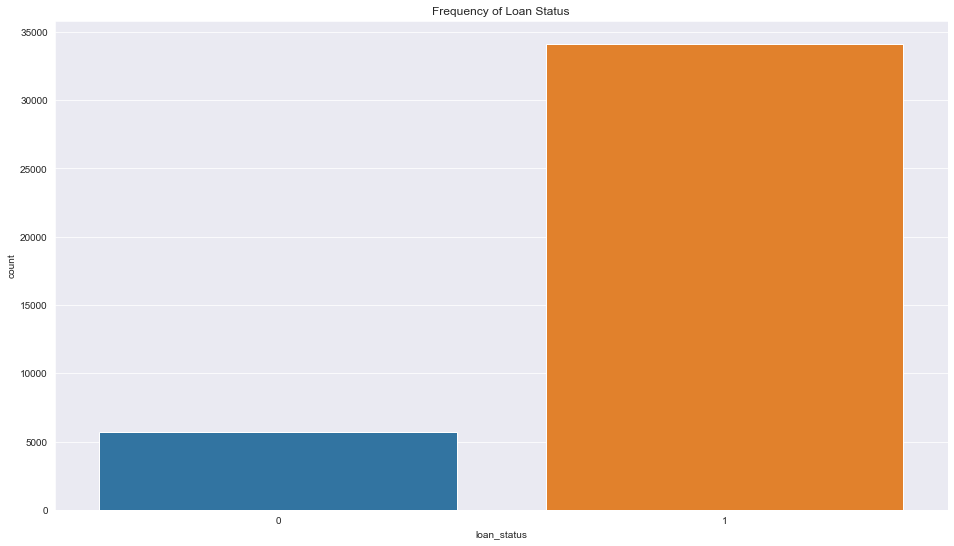

In [63]:

fig = plt.figure(figsize = (16,9))
sns.set_style('darkgrid')
sns.countplot(loan_df.loan_status).set_title('Frequency of Loan Status')
plt.show()

In [64]:
print(f"Percentage of borrowers with loans fully paid: {round(sum(loan_df.loan_status == 1)/len(loan_df.loan_status) * 100,2)} %")

Percentage of borrowers with loans fully paid: 85.75 %


### Handle Missing Data/Categoricals

In [65]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39783 entries, 0 to 39782
Data columns (total 24 columns):
loan_amnt              39783 non-null float64
term                   39783 non-null object
installment            39783 non-null float64
grade                  39783 non-null object
emp_length             38705 non-null object
home_ownership         39783 non-null object
annual_inc             39783 non-null float64
verification_status    39783 non-null object
loan_status            39783 non-null int64
purpose                39783 non-null object
title                  39772 non-null object
addr_state             39783 non-null object
dti                    39783 non-null float64
delinq_2yrs            39783 non-null float64
earliest_cr_line       39783 non-null object
inq_last_6mths         39783 non-null float64
open_acc               39783 non-null float64
pub_rec                39783 non-null float64
revol_bal              39783 non-null float64
revol_util             39733

In [66]:
loan_df = loan_df.dropna()

In [67]:
loan_df.dtypes.value_counts()

float64    12
object     11
int64       1
dtype: int64

In [68]:
loan_df.revol_util = loan_df.revol_util.str.rstrip('%').astype('float')
loan_df_objects = loan_df.select_dtypes(include = ['object'])
print(loan_df_objects.iloc[0])

term                     36 months
grade                            B
emp_length               10+ years
home_ownership                RENT
verification_status       Verified
purpose                credit_card
title                     Computer
addr_state                      AZ
earliest_cr_line          Jan-1985
last_credit_pull_d        Dec-2019
Name: 0, dtype: object


In [69]:
#Drop addr_state (too many values)
drops = ['last_credit_pull_d', 'addr_state', 'title', 'earliest_cr_line']
loan_df = loan_df.drop(drops, axis = 1)

In [70]:
display(loan_df.emp_length.value_counts())
display(loan_df.grade.value_counts())

10+ years    8896
< 1 year     4576
2 years      4389
3 years      4093
4 years      3435
5 years      3279
1 year       3239
6 years      2227
7 years      1771
8 years      1483
9 years      1258
Name: emp_length, dtype: int64

B    11694
A     9692
C     7924
D     5194
E     2799
F     1028
G      315
Name: grade, dtype: int64

In [71]:
#Create mapping dictionary for ordinal categorical values
ordinal_dict = {"emp_length" : {
                                "10+ years": 10,
                                "9 years": 9,
                                "8 years": 8,
                                "7 years": 7,
                                "6 years": 6,
                                "5 years": 5,
                                "4 years": 4,
                                "3 years": 3,
                                "2 years": 2,
                                "1 year": 1,
                                "< 1 year": 0,
                                "n/a": 0},
                "grade" : {
                    "A": 1,
                    "B": 2,
                    "C": 3,
                    "D": 4,
                    "E": 5,
                    "F": 6,
                    "G": 7
                }}

loan_df = loan_df.replace(ordinal_dict)


In [72]:
# Create dummy variables for nominal values

In [73]:
nominals = ['home_ownership', 'verification_status', 'purpose', 'term']
dummy_loan_df = pd.get_dummies(loan_df[nominals])
loan_df = pd.concat([loan_df, dummy_loan_df], axis = 1)
loan_df = loan_df.drop(nominals, axis = 1)

In [74]:
loan_df.head()

,loan_amnt,installment,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,5000.0,162.87,2,10,24000.0,1,27.65,0.0,1.0,3.0,...,0,0,0,0,0,0,0,0,1,0
1,2500.0,59.83,3,0,30000.0,0,1.00,0.0,5.0,3.0,...,0,0,0,0,0,0,0,0,0,1
2,2400.0,84.33,3,10,12252.0,1,8.72,0.0,2.0,2.0,...,0,0,0,0,0,1,0,0,1,0
3,10000.0,339.31,3,10,49200.0,1,20.00,0.0,1.0,10.0,...,0,0,0,1,0,0,0,0,1,0
4,3000.0,67.79,2,1,80000.0,1,17.94,0.0,0.0,15.0,...,0,0,0,1,0,0,0,0,0,1


# Classification Modeling

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
warnings.filterwarnings('ignore')

### Train Test Split

In [76]:
X = loan_df.drop(columns = 'loan_status')
y = loan_df.loan_status

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 33)

### SMOTE

In [78]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

## Random Forest

In [79]:
#Criterion: Gini Coefficient
classifier = DecisionTreeClassifier(random_state = 33)
classifier.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=33, splitter='best')

In [80]:
y_pred = classifier.predict(X_test)

In [81]:
acc = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy is: {round(acc,2)}%")

#Check predictions-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f"\nAUC is: {round(roc_auc, 2)}")

#Confusion Matrix
print('---------------------------')
print("\nConfusion Matrix:\n")
print(pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))

Accuracy is: 76.68%

AUC is: 0.54
---------------------------

Confusion Matrix:

Predicted     0     1   All
True                       
0           243   872  1115
1           931  5684  6615
All        1174  6556  7730


In [82]:
#Train DT Classifier (Criterion: Entropy)
classifier2 = DecisionTreeClassifier(random_state = 33, criterion = 'entropy')
classifier2.fit(X_train_resampled, y_train_resampled)
y_pred = classifier2.predict(X_test)
acc = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy is: {round(acc,2)}%")

#Check predictions-AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f"\nAUC is: {round(roc_auc, 2)}")

#Confusion Matrix
print('---------------------------')
print("\nConfusion Matrix:\n")
print(pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))


Accuracy is: 76.51%

AUC is: 0.53
---------------------------

Confusion Matrix:

Predicted     0     1   All
True                       
0           232   883  1115
1           933  5682  6615
All        1165  6565  7730


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

<Figure size 2160x2160 with 0 Axes>

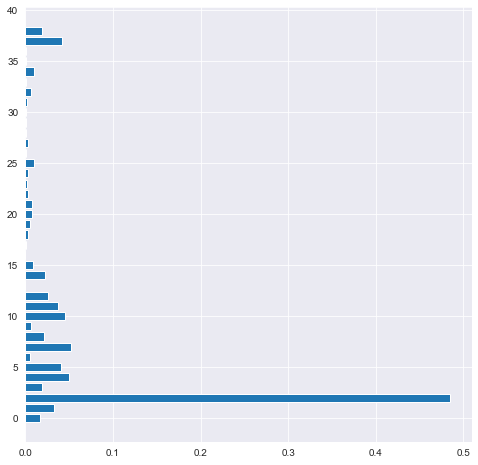

In [83]:
# Feature Importance
classifier2.feature_importances_
def plot_feature_importances(model):
    plt.figure(figsize = (30,30))
    n_features = X_train_resampled.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_resampled.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(classifier2)

In [84]:
pred = classifier2.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 232  883]
 [ 933 5682]]
              precision    recall  f1-score   support

           0       0.20      0.21      0.20      1115
           1       0.87      0.86      0.86      6615

    accuracy                           0.77      7730
   macro avg       0.53      0.53      0.53      7730
weighted avg       0.77      0.77      0.77      7730



In [85]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 6)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [86]:
forest.score(X_train_resampled, y_train_resampled)

0.8780066145520145

In [87]:
forest.score(X_test, y_test)

0.8205692108667529

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

<Figure size 2160x2160 with 0 Axes>

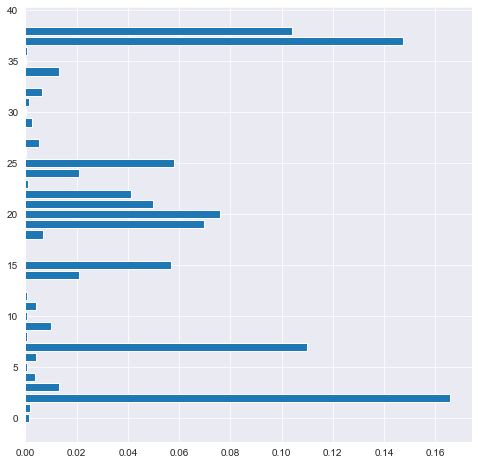

In [88]:
plot_feature_importances(forest)

In [89]:
#Hyperparameter Selection
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators':[30,100,300],
    'min_samples_split':[2,4,6],
    'min_samples_leaf':[2,4,6]
}

In [90]:
gs = GridSearchCV(forest, param_grid, cv = 5)
gs.fit(X_train_resampled, y_train_resampled)
gs.score(X_test, y_test)
gs.best_params_

{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

In [91]:
classifier3 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', min_samples_leaf = 6, min_samples_split = 4)
classifier3.fit(X_train_resampled, y_train_resampled)
classifier3.predict(X_test)
print(f"Train Accuracy Score: {classifier3.score(X_train_resampled, y_train_resampled)}")
print(f"Test Accuracy Score: {classifier3.score(X_test, y_test)}")
print(f"\nAUC is: {round(roc_auc, 2)}")

Train Accuracy Score: 0.9309230306674684
Test Accuracy Score: 0.8545924967658474

AUC is: 0.53
